In [2]:
from IPython import get_ipython

# method to check if the dependencies needs to be installed
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install opencv-python matplotlib mediapipe
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not running in Google Collab")

Not running in Google Collab


In [3]:
from IPython.display import display, Image, clear_output
import os
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import time

In [4]:
# Load the mediapipe model
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose_drawing_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)

In [5]:
# Function to process the frames using MediaPipe
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB to BGR
    return image, results

In [6]:
# Function to check if the squat depth is sufficient
def is_depth_sufficient(results):
    """
    Check if the depth of the squat is sufficient.
    @param results: MediaPipe results
    @return: True if the depth is sufficient, False otherwise
    """
    if results.pose_landmarks:
        left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
        right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
        left_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE]
        right_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
        hips_height = (left_hip.y + right_hip.y) / 2
        knees_height = (left_knee.y + right_knee.y) / 2

        # Check if hips are lower than knees (indicating sufficient depth)
        return hips_height > knees_height
    return False

In [7]:
# Function to check if there is knee cave
def is_knee_cave(results):
    """
    Check if there is knee cave based on knee, hip, and ankle landmarks.
    @param results: MediaPipe results
    @return: True if knee cave is detected, False otherwise
    """
    if results.pose_landmarks:
        left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
        right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
        left_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE]
        right_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
        left_ankle = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE]
        right_ankle = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE]
        hips_width = abs(left_hip.x - right_hip.x)
        knees_width = abs(left_knee.x - right_knee.x)
        ankles_width = abs(left_ankle.x - right_ankle.x)

        # Check if knees are closer to each other than hips and ankles
        return knees_width < hips_width and knees_width < ankles_width
    return False

In [22]:
# Function to check if the knees are over toes
def are_knees_over_toes(results):
    """
    Check if the knees are over the toes based on knee, hip, and ankle landmarks.
    @param results: MediaPipe results
    @return: True if knees are over the toes, False otherwise
    """
    if results.pose_landmarks:
        left_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE]
        right_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
        left_foot_index = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_FOOT_INDEX]
        right_foot_index = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]
        knees_z_mean = (left_knee.z + right_knee.z) / 2
        foot_z_mean = (left_foot_index.z + right_foot_index.z) / 2

        # Check if knees are over the toes
        return knees_z_mean < foot_z_mean
    return False

In [20]:
# Function to process each frame and check for depth and knee cave
def process_frame(results, consecutive_sufficient_depth_count, consecutive_knee_cave_count, consecutive_knees_over_toes_count, CONSECUTIVE_THRESHOLD):
    """
    Process each frame, checking for sufficient depth and knee cave.
    @param results: MediaPipe results
    @return: Updated counters and boolean values for detection
    """
    if is_depth_sufficient(results):
        consecutive_sufficient_depth_count += 1
    else:
        consecutive_sufficient_depth_count = 0

    if is_knee_cave(results):
        consecutive_knee_cave_count += 1
    else:
        consecutive_knee_cave_count = 0

    if are_knees_over_toes(results):
        consecutive_knees_over_toes_count += 1
    else:
        consecutive_knees_over_toes_count = 0

    sufficient_depth_detected = consecutive_sufficient_depth_count >= CONSECUTIVE_THRESHOLD
    knee_cave_detected = consecutive_knee_cave_count >= CONSECUTIVE_THRESHOLD
    knees_over_toes_detected = consecutive_knees_over_toes_count >= CONSECUTIVE_THRESHOLD

    return consecutive_sufficient_depth_count, consecutive_knee_cave_count, sufficient_depth_detected, knee_cave_detected, knees_over_toes_detected

In [9]:
# Function to draw keypoints on the frame
def draw_keypoints(image, results):
    """
    Draw keypoints and connections on the frame.
    @param image: The frame to draw on
    @param results: MediaPipe results with landmarks
    """
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=pose_drawing_spec,
            connection_drawing_spec=pose_drawing_spec
        )

In [10]:
# Function to display the frame in Jupyter Notebook
def display_frame(image):
    """
    Display the frame in Jupyter Notebook.
    @param image: The frame to display
    """
    clear_output(wait=True)  # Clear previous output
    temp_filename = "./temp_frame.jpg"  # Save frame temporarily
    cv2.imwrite(temp_filename, image)   # Save the frame as an image file
    display(Image(filename=temp_filename))  # Display the frame in Jupyter Notebook
    return temp_filename

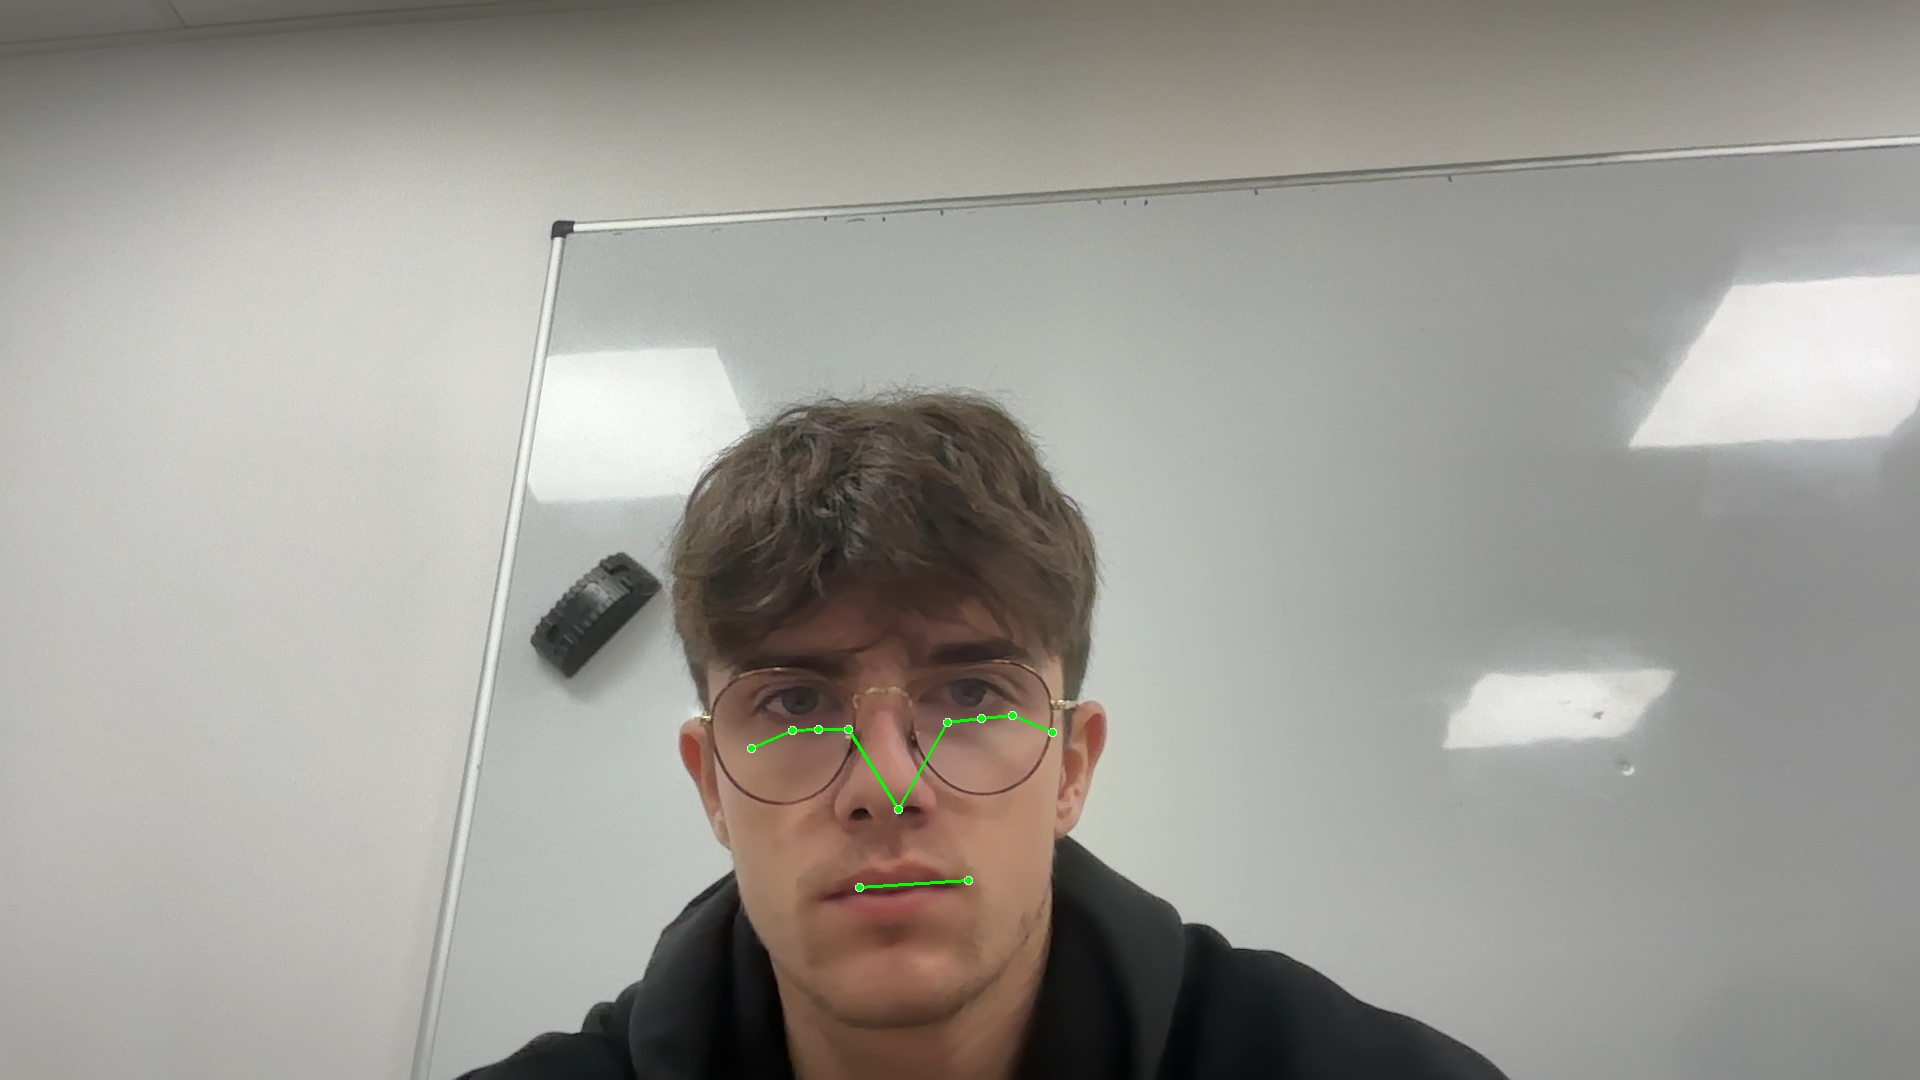

No sufficient depth
No knee cave
Knees not over toes
Deleted temporary file: ./temp_frame.jpg


In [24]:
cap = cv2.VideoCapture(0)  # Use `0` for the default camera

# Initialize variables
sufficient_depth_detected = False
knee_cave_detected = False

consecutive_sufficient_depth_count = 0
consecutive_knee_cave_count = 0
consecutive_knees_over_toes_count = 0

CONSECUTIVE_THRESHOLD = 4
RUN_DURATION = 5  # 10 seconds duration
start_time = time.time()

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Apply MediaPipe detection
        image, results = mediapipe_detection(frame, pose)
        # Process each frame

        consecutive_sufficient_depth_count, consecutive_knee_cave_count, sufficient_depth_detected, knee_cave_detected, knees_over_toes_detected = process_frame(
            results, consecutive_sufficient_depth_count, consecutive_knee_cave_count, consecutive_knees_over_toes_count, CONSECUTIVE_THRESHOLD)
        
        # Draw keypoints on the frame
        draw_keypoints(image, results)

        # Display the frame in Jupyter Notebook
        temp_filename = display_frame(image)

        # Check if 10 seconds have passed
        if time.time() - start_time > RUN_DURATION:
            break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

# Check the final result
if sufficient_depth_detected:
    print("Sufficient depth")
else:
    print("No sufficient depth")

if knee_cave_detected:
    print("Knee cave")
else:
    print("No knee cave")

if knees_over_toes_detected:
    print("Knees over toes")
else:
    print("Knees not over toes")

# Delete the temporary image file if it exists
if os.path.exists(temp_filename):
    os.remove(temp_filename)
    print(f"Deleted temporary file: {temp_filename}")